In [7]:
from datetime import datetime, timedelta

import numpy as np

from stonesoup.models.transition.categorical import MarkovianTransitionModel
from stonesoup.types.groundtruth import CategoricalGroundTruthState
from stonesoup.types.groundtruth import GroundTruthPath

transition_matrix = np.array([[0.8, 0.2],  # P(bike | bike), P(bike | car)
                              [0.4, 0.6]])  # P(car | bike), P(car | car)
category_transition = MarkovianTransitionModel(transition_matrix=transition_matrix)

start = datetime.now()

hidden_classes = ['bike', 'car']

# Generating ground truth
ground_truths = list()
for i in range(1, 4):  # 4 targets
    state_vector = np.zeros(2)  # create a vector with 2 zeroes
    state_vector[np.random.choice(2, 1, p=[1 / 2, 1 / 2])] = 1  # pick a random class out of the 2
    ground_truth_state = CategoricalGroundTruthState(state_vector,
                                                     timestamp=start,
                                                     categories=hidden_classes)

    ground_truth = GroundTruthPath([ground_truth_state], id=f"GT{i}")

    for _ in range(10):
        new_vector = category_transition.function(ground_truth[-1],
                                                  noise=True,
                                                  time_interval=timedelta(seconds=1))
        new_state = CategoricalGroundTruthState(
            new_vector,
            timestamp=ground_truth[-1].timestamp + timedelta(seconds=1),
            categories=hidden_classes
        )

        ground_truth.append(new_state)
    ground_truths.append(ground_truth)

for states in np.vstack(ground_truths).T:
    print(f"{states[0].timestamp:%H:%M:%S}", end="")
    for state in states:
        print(f" -- {state.category}", end="")
    print()
    
from stonesoup.models.measurement.categorical import MarkovianMeasurementModel
from stonesoup.sensor.categorical import HMMSensor

E = np.array([[0.8, 0.1],  # P(small | bike), P(small | car)
              [0.19, 0.3],  # P(medium | bike), P(medium | car)
              [0.01, 0.6]])  # P(large | bike), P(large | car)

model = MarkovianMeasurementModel(emission_matrix=E,
                                  measurement_categories=['small', 'medium', 'large'])

eo = HMMSensor(measurement_model=model)

# Generating measurements
measurements = list()
for index, states in enumerate(np.vstack(ground_truths).T):
    if index == 5:
        measurements_at_time = set()  # Give tracker chance to use prediction instead
    else:
        measurements_at_time = eo.measure(states)
    timestamp = next(iter(states)).timestamp
    measurements.append((timestamp, measurements_at_time))

    print(f"{timestamp:%H:%M:%S} -- {[meas.category for meas in measurements_at_time]}")
    
from stonesoup.predictor.categorical import HMMPredictor

# It would be cheating to use the same transition model as in ground truth generation!
transition_matrix = np.array([[0.81, 0.19],  # P(bike | bike), P(bike | car)
                              [0.39, 0.61]])  # P(car | bike), P(car | car)
category_transition = MarkovianTransitionModel(transition_matrix=transition_matrix)

predictor = HMMPredictor(category_transition)

from stonesoup.updater.categorical import HMMUpdater

updater = HMMUpdater()

from stonesoup.hypothesiser.categorical import HMMHypothesiser

hypothesiser = HMMHypothesiser(predictor=predictor, updater=updater)

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment

data_associator = GNNWith2DAssignment(hypothesiser)

from stonesoup.types.state import CategoricalState

prior = CategoricalState([1 / 2, 1 / 2], categories=hidden_classes)

from stonesoup.initiator.categorical import SimpleCategoricalMeasurementInitiator

initiator = SimpleCategoricalMeasurementInitiator(prior_state=prior, updater=updater)

from stonesoup.deleter.time import UpdateTimeStepsDeleter

deleter = UpdateTimeStepsDeleter(2)

from stonesoup.tracker.simple import MultiTargetTracker

tracker = MultiTargetTracker(initiator, deleter, measurements, data_associator, updater)

tracks = set()
for time, ctracks in tracker:
    tracks.update(ctracks)

print(f"Number of tracks: {len(tracks)}")
for track in tracks:
    certainty = track.state_vector[np.argmax(track.state_vector)][0] * 100
    print(f"id: {track.id} -- category: {track.category} -- certainty: {certainty}%")
    for state in track:
        _time = state.timestamp.strftime('%H:%M')
        _type = str(type(state)).replace("class 'stonesoup.types.", "").strip("<>'. ")
        state_string = f"{_time} -- {_type} -- {state.category}"
        try:
            meas_string = f"associated measurement: {state.hypothesis.measurement.category}"
        except AttributeError:
            pass
        else:
            state_string += f" -- {meas_string}"
        print(state_string)
    print()

18:37:29 -- bike -- car -- bike
18:37:30 -- bike -- car -- bike
18:37:31 -- bike -- car -- bike
18:37:32 -- car -- car -- bike
18:37:33 -- bike -- car -- car
18:37:34 -- car -- bike -- car
18:37:35 -- car -- car -- car
18:37:36 -- car -- car -- car
18:37:37 -- car -- car -- bike
18:37:38 -- bike -- car -- bike
18:37:39 -- bike -- car -- car
18:37:29 -- ['medium', 'large', 'medium']
18:37:30 -- ['medium', 'small', 'small']
18:37:31 -- ['large', 'small', 'medium']
18:37:32 -- ['medium', 'large', 'small']
18:37:33 -- ['large', 'large', 'small']
18:37:34 -- []
18:37:35 -- ['large', 'medium', 'large']
18:37:36 -- ['large', 'medium', 'medium']
18:37:37 -- ['large', 'large', 'small']
18:37:38 -- ['large', 'small', 'small']
18:37:39 -- ['medium', 'small', 'medium']
Number of tracks: 3
id: bf5407eb-4039-4e24-a0f0-394225ae7c95 -- category: car -- certainty: 83.34948005474784%
18:37 -- update.CategoricalStateUpdate -- car -- associated measurement: large
18:37 -- update.CategoricalStateUpdate -- 

Excess tracks: 0
No. correct classifications: 3


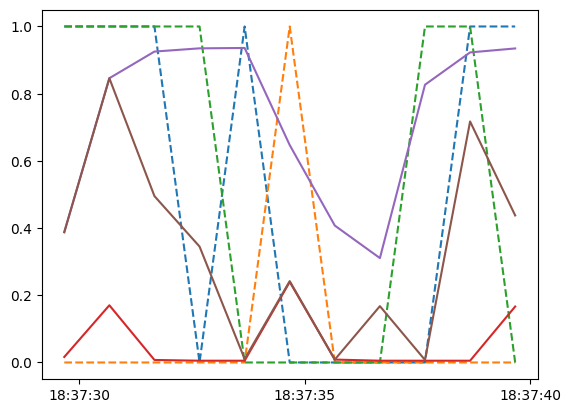

In [8]:
excess_tracks = len(tracks) - len(ground_truths)  # target value = 0
sorted_tracks = sorted(tracks,
                       key=lambda track: track.state_vector[np.argmax(track.state_vector)][0],
                       reverse=True)
best_tracks = sorted_tracks[:3]
true_classifications = [ground_truth.category for ground_truth in ground_truths]
track_classifications = [track.category for track in best_tracks]

num_correct_classifications = 0  # target value = num ground truths
for true_classification in true_classifications:
    for i in range(len(track_classifications)):
        if track_classifications[i] == true_classification:
            num_correct_classifications += 1
            del track_classifications[i]
            break

print(f"Excess tracks: {excess_tracks}")
print(f"No. correct classifications: {num_correct_classifications}")

import matplotlib.pyplot as plt


def plot(path, style):
    times = list()
    probs = list()
    for state in path:
        times.append(state.timestamp)
        probs.append(state.state_vector[0])
    plt.plot(times, probs, linestyle=style)


for truth in ground_truths:
    plot(truth, '--')
for track in tracks:
    plot(track, '-')